DATA CREATION

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 1000

signup_dates = pd.to_datetime(np.random.choice(pd.date_range("2022-01-01", "2023-01-01"), n))
lifetimes = np.random.exponential(scale=180, size=n).astype(int)
end_dates = signup_dates + pd.to_timedelta(lifetimes, unit='D')

# Simulate churn: 70% churned, 30% still active
churned = np.random.choice([1, 0], size=n, p=[0.7, 0.3])
end_dates = end_dates.to_numpy()  # make mutable
end_dates[churned == 0] = pd.to_datetime("2023-12-31")  # still active
end_dates = pd.to_datetime(end_dates)  # convert back to DatetimeIndex

df = pd.DataFrame({
    'User_ID': range(1, n + 1),
    'Signup_Date': signup_dates,
    'End_Date': end_dates,
    'Churned': churned
})
df['Duration'] = (df['End_Date'] - df['Signup_Date']).dt.days
df.to_csv("subscription_survival.csv", index=False)


## Tasks:
1. Use Kaplan-Meier estimation to plot the survival curve

2. What’s the median survival time of customers?

3. Plot a hazard function (optional: via cumulative difference or lifelines lib)

4. If available, compare churn by cohort (e.g., signup quarter)

In [2]:
df.head()

,User_ID,Signup_Date,End_Date,Churned,Duration
0,1,2022-04-13,2023-08-09,1,483
1,2,2022-12-15,2023-12-31,0,381
2,3,2022-09-28,2023-03-09,1,162
3,4,2022-04-17,2022-07-08,1,82
4,5,2022-03-13,2023-12-31,0,658


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   User_ID      1000 non-null   int64         
 1   Signup_Date  1000 non-null   datetime64[ns]
 2   End_Date     1000 non-null   datetime64[ns]
 3   Churned      1000 non-null   int64         
 4   Duration     1000 non-null   int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 39.2 KB


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

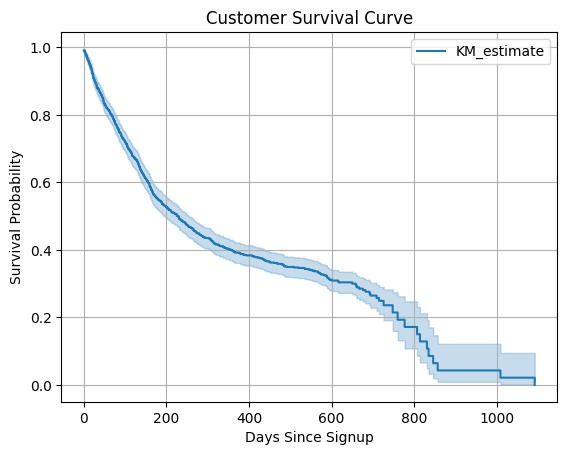

In [5]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(durations=df['Duration'], event_observed=df['Churned'])

kmf.plot_survival_function()
plt.title("Customer Survival Curve")
plt.xlabel("Days Since Signup")
plt.ylabel("Survival Probability")
plt.grid()
plt.show()


In [6]:
median_time = kmf.median_survival_time_
print("Median Survival Time (days):", median_time)

Median Survival Time (days): 227.0


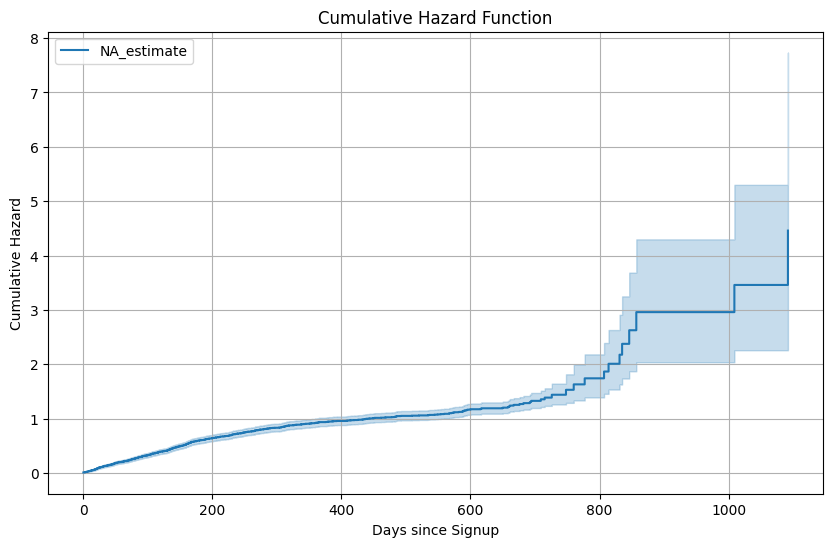

In [7]:
naf = NelsonAalenFitter()
naf.fit(df['Duration'], event_observed=df['Churned'])

# Plot cumulative hazard
plt.figure(figsize=(10, 6))
naf.plot()
plt.title("Cumulative Hazard Function")
plt.xlabel("Days since Signup")
plt.ylabel("Cumulative Hazard")
plt.grid(True)
plt.show()


In [10]:
# Create Signup_Quarter column
df['Signup_Quarter'] = df['Signup_Date'].dt.to_period('Q')

In [12]:
df['Signup_Quarter']

0      2022Q2
1      2022Q4
2      2022Q3
3      2022Q2
4      2022Q1
        ...  
995    2022Q2
996    2022Q4
997    2022Q1
998    2022Q4
999    2022Q2
Name: Signup_Quarter, Length: 1000, dtype: period[Q-DEC]

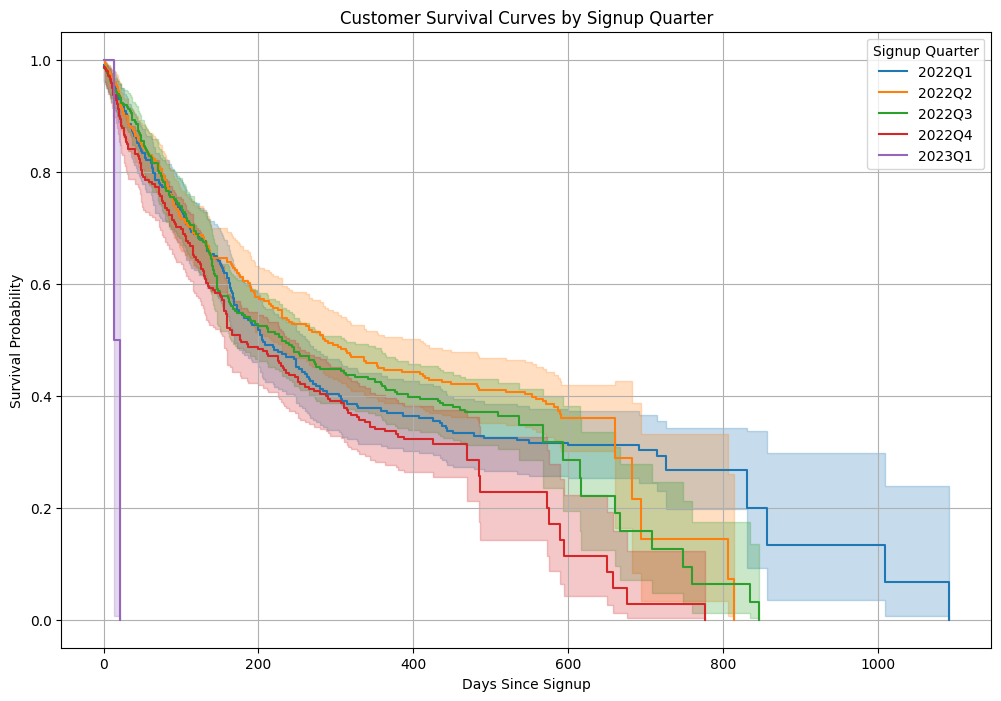

In [ ]:

# Group by quarter and calculate churn rate

plt.figure(figsize=(12, 8))

for quarter, group in df.groupby('Signup_Quarter'):
    T = group['Duration']
    E = group['Churned']
    kmf.fit(durations=T, event_observed=E, label=quarter)
    kmf.plot_survival_function()
    
plt.title("Customer Survival Curves by Signup Quarter")
plt.xlabel("Days Since Signup")
plt.ylabel("Survival Probability")
plt.legend(title='Signup Quarter')
plt.grid()
plt.show()

In [16]:
kmf.fit(durations=df['Duration'], event_observed=df['Churned'])

# Survival probability at 90 days
survival_at_90 = kmf.predict(90)

# So, % who churned by day 90 = 1 - survival probability at day 90
churn_percent_by_90 = (1 - survival_at_90) * 100
print(f"Estimated {churn_percent_by_90:.2f}% of customers churned within 90 days (Kaplan-Meier).")

Estimated 25.90% of customers churned within 90 days (Kaplan-Meier).


## 🔹 Approximate Hazard Function Formula

The discrete-time approximation of the hazard function is:

$$
\text{Hazard}(t) \approx \frac{S(t) - S(t + 1)}{S(t)}
$$

Where:
- \( S(t) \) is the survival probability at time \( t \)
- \( S(t+1) \) is the survival probability at the next time step

In [17]:
# Approximate hazard from survival function
sf = kmf.survival_function_
hazard = (sf - sf.shift(-1)) / sf
hazard.columns = ['Hazard']
hazard = hazard.dropna()


In [19]:
peak_day = hazard['Hazard'].idxmax()
peak_hazard = hazard['Hazard'].max()

print(f"Highest hazard (drop-off spike) occurs at day {peak_day},")
print(f"with an estimated hazard rate of {peak_hazard:.4f}")


Highest hazard (drop-off spike) occurs at day 1009.0,
with an estimated hazard rate of 1.0000


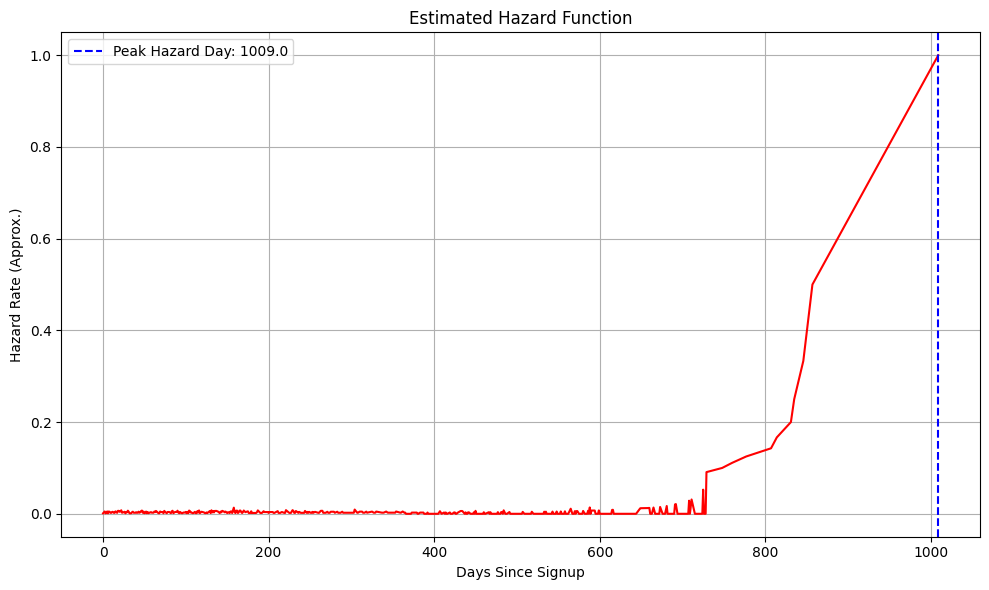

In [20]:
plt.figure(figsize=(10,6))
plt.plot(hazard.index, hazard['Hazard'], color='red')
plt.axvline(x=peak_day, color='blue', linestyle='--', label=f"Peak Hazard Day: {peak_day}")
plt.title("Estimated Hazard Function")
plt.xlabel("Days Since Signup")
plt.ylabel("Hazard Rate (Approx.)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
